In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [7]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [8]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [9]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [10]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

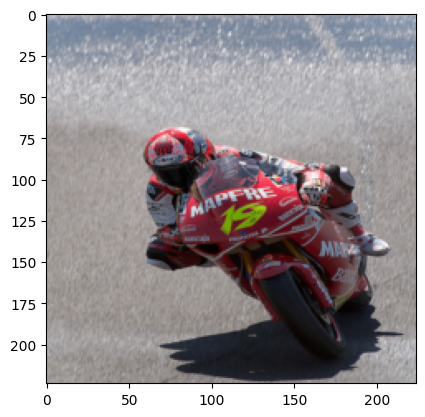

In [11]:
display_image(Images,1)

# Preprocessing Captions

In [12]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [13]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [14]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [15]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [16]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [17]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [18]:
train_split = int(0.8*len(list_of_files))
val_split = ((len(list_of_files) - train_split)//2 )
test_split = len(list_of_files) - train_split - val_split

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:train_split+val_split]
test_files = list_of_files[train_split+val_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:train_split+val_split,:,:,:]
test_images = Images[train_split+val_split:,:,:,:]


In [19]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [20]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> boy jumps from swing set <end>', '<start> child is jumping from swing and is in midair <end>', '<start> child jumping out of swing toward target placed on the ground <end>', '<start> child jumps off swing and flies toward landing pad <end>', '<start> child jumps off of swing while it is in motion <end>']


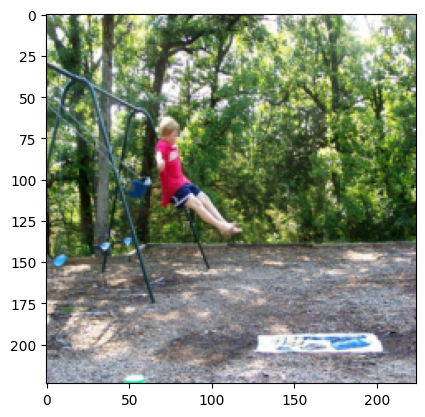

In [21]:
print(train_captions[0])
display_image(train_images,0)

In [22]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7867
6472
6472


# Captions Dataset

In [23]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [24]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [25]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [26]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super(CNN_model_1,self).__init__()
        vgg=models.vgg19(pretrained=True)
        for p in vgg.parameters():
            p.requires_grad_(False)
        modules=list(vgg.children())[:-2]
        self.vgg=nn.Sequential(*modules)
    def forward(self,images):
        features=self.vgg(images)
        features=features.permute(0,2,3,1)
        features=features.view(features.size(0),-1,features.size(-1))
#         print(features.shape)
        return features #(batch_size,49,2048)

# LSTM and Transformer part of the decoder

In [27]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
        self.U=nn.Linear(512,512)
        self.W=nn.Linear(512,512)
        self.v=nn.Linear(512,1)
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(1)

    def forward(self,features,hidden_states):
        U_hidden=self.U(hidden_states)#(batch_size,512)
        W_features=self.W(features)#(batch_size,49,512)
        attention=self.tanh(U_hidden.unsqueeze(1)+W_features)
        e=self.v(attention).squeeze(2) #(batch_size,1)
        alpha=self.softmax(e)
        context=(features*alpha.unsqueeze(2)).sum(1)
        return alpha,context

In [28]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention()
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)  
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds,alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  
        alphas = []
        word = torch.tensor(vocab[1]['<start>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab[0][predicted_word_idx.item()] == "<end>":
                break
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        return " ".join([vocab[0][idx] for idx in captions])


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

# Integrating the 2 parts of the model

In [29]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs,alpha = self.decoder(features,captions)
    return features,outputs,alpha

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.generate_captions(features)
    return prediction


In [30]:
def validate(model):
  actual_captions = []
  generated_captions = []
  for data in val_loader:
    image, caption_set = data
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab).split())
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  return bleu

In [31]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for i,(img,cap,caplen) in tqdm(enumerate(train_loader)):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs,alpha = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap[:,1:].reshape(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
                perp = np.exp(loss.item())
            average_loss = average_loss/count
            averge_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = model
              best_bleu = bleu
      return model,best_checkpoint_model

# Calling Functions

In [32]:
learning_rate = 0.0003
num_epochs = 1
embed_size=300
hidden_size=512
attention_size = 256
vocab_size=len(vocab[0])
n_layers=2

In [33]:
# decoder = (embed_size,hidden_size,vocab_size,n_layers)
decoder = DecoderRNN(embed_size,vocab_size,attention_size,512,hidden_size)
encoder = CNN_model_1()
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 61.7MB/s] 


In [34]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [35]:
best_checkpoint_model,final_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 10)

6472it [02:56, 36.61it/s]


Epoch [1/10], Loss: 4.7481, Perplexity: 31.8436
BLEU-1: 0.4668992309947116
BLEU-2: 0.2402773123796198
BLEU-3: 0.13527203798035037
BLEU-4: 0.07610491281937425
BLEU:0.18434831080717526
checkpointing best model


6472it [02:51, 37.68it/s]


Epoch [2/10], Loss: 4.1323, Perplexity: 24.6254
BLEU-1: 0.46172026799271143
BLEU-2: 0.24665013541077163
BLEU-3: 0.145393878574642
BLEU-4: 0.08524646659713385
BLEU:0.1938298686940527
checkpointing best model


6472it [02:51, 37.66it/s]


Epoch [3/10], Loss: 3.8983, Perplexity: 43.7136
BLEU-1: 0.4621510873934925
BLEU-2: 0.2501374225240273
BLEU-3: 0.14686119424049665
BLEU-4: 0.08722078845988801
BLEU:0.1961654091200769
checkpointing best model


6472it [02:51, 37.67it/s]


Epoch [4/10], Loss: 3.7718, Perplexity: 14.0758
BLEU-1: 0.44888620924171274
BLEU-2: 0.24040865913995593
BLEU-3: 0.14069133632491074
BLEU-4: 0.08264540841758998
BLEU:0.1882101815242016


6472it [02:49, 38.12it/s]


Epoch [5/10], Loss: 3.6794, Perplexity: 10.9134
BLEU-1: 0.4661981614687907
BLEU-2: 0.2576943573141358
BLEU-3: 0.15357656023817517
BLEU-4: 0.09298892405764474
BLEU:0.2035203805712928
checkpointing best model


6472it [02:50, 38.06it/s]


Epoch [6/10], Loss: 3.5993, Perplexity: 34.9483
BLEU-1: 0.4464339806768762
BLEU-2: 0.2464809754982491
BLEU-3: 0.14762446829169534
BLEU-4: 0.088260080458649
BLEU:0.19458789873549648


6472it [02:49, 38.10it/s]


Epoch [7/10], Loss: 3.5296, Perplexity: 150.5353
BLEU-1: 0.44756400265262936
BLEU-2: 0.2379311788473902
BLEU-3: 0.13738769207956295
BLEU-4: 0.07948831599951313
BLEU:0.1846670482801482


6472it [02:50, 37.87it/s]


Epoch [8/10], Loss: 3.4813, Perplexity: 10.9947
BLEU-1: 0.46934176495117497
BLEU-2: 0.2588699211836155
BLEU-3: 0.15241077313073653
BLEU-4: 0.08904035241253506
BLEU:0.20150848250349013


6472it [02:50, 38.04it/s]


Epoch [9/10], Loss: 3.4392, Perplexity: 184.7019
BLEU-1: 0.4423340047042609
BLEU-2: 0.24216299325625523
BLEU-3: 0.1415439478902093
BLEU-4: 0.08172822951295518
BLEU:0.1876205370290549


6472it [02:50, 38.05it/s]


Epoch [10/10], Loss: 3.4266, Perplexity: 87.8543
BLEU-1: 0.44662794793725374
BLEU-2: 0.23780775859799053
BLEU-3: 0.1389192887122992
BLEU-4: 0.08049738309524589
BLEU:0.18564320478197935


In [ ]:
best_checkpoint_model,final_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 5)

# Generating Captions

In [36]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions = model.decoder.generate_caption(model.encoder(image.to(device)), vocab = vocab)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)

black dog is biting another dog <end>


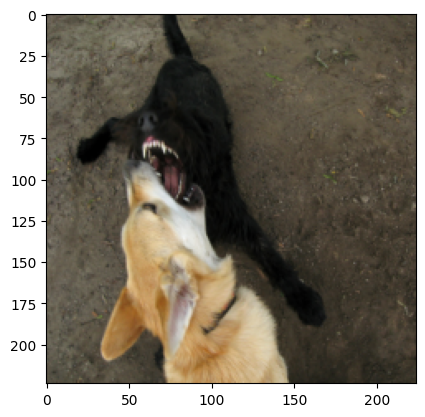

In [45]:
generate_captions_for_random_image(model)

man in red uniform is riding motorcycle <end>


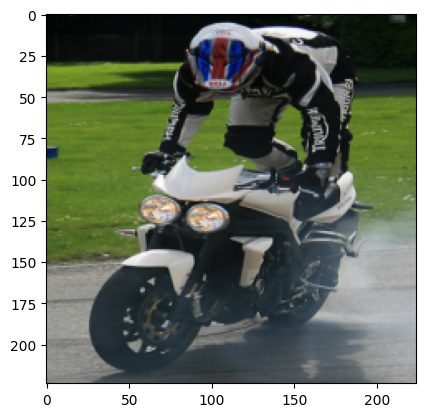

In [48]:
generate_captions_for_random_image(model)

dog is in pool <end>


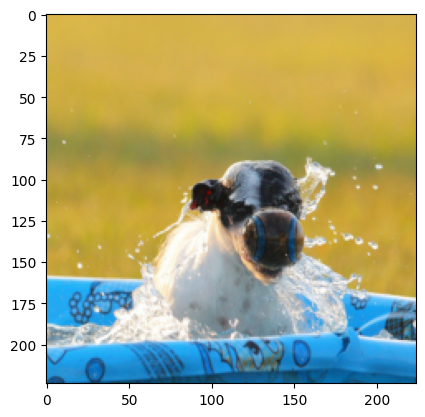

In [39]:
generate_captions_for_random_image(model)

man is sitting on bench <end>


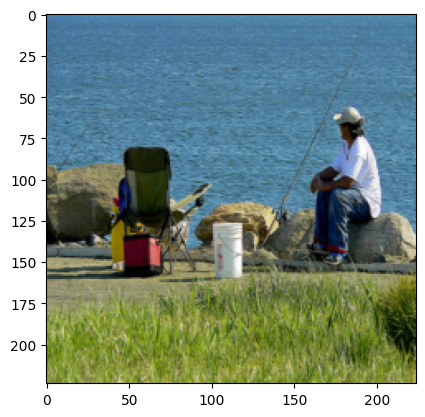

In [40]:
generate_captions_for_random_image(model)

woman with sunglasses and smiles <end>


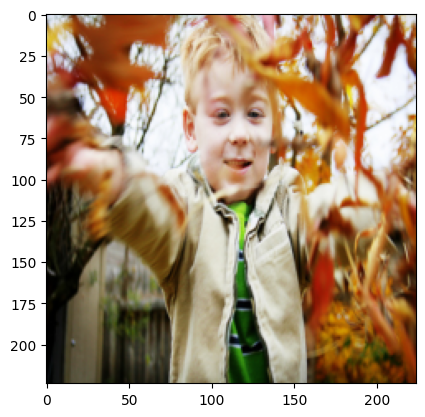

In [41]:
generate_captions_for_random_image(model)

man is riding kayak through rough waters <end>


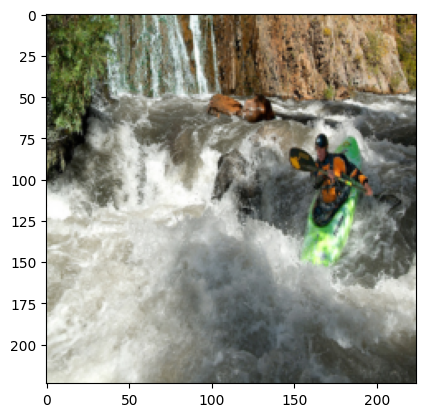

In [49]:
generate_captions_for_random_image(model)